# Custom Training Job with Tensorboard Monitoring

This notebook demonstrates how to submit a custom Vertex training job and monitor it using Vertex TensorBoard. 

## Scenario

The training scenario is fine-tuning BERT on the [GLUE COLA](https://nyu-mll.github.io/CoLA/) dataset. 

## Notes

- The training regimen utilizes  [TensorFlow NLP Modelling Toolkit](https://github.com/tensorflow/models/tree/master/official/nlp)
- Due to a complexity of the ML task, the custom training job is configured to use a multi-gpu training node

In [1]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text  # A dependency of the preprocessing model
import tensorflow_addons as tfa
from official.nlp import optimization
import numpy as np

tf.get_logger().setLevel('ERROR')

## Evironment setup

### Set GCP project and GCS bucket

In [2]:
PROJECT = 'jk-mlops-dev'
GCS_BUCKET = 'gs://jk-vertex-workshop-bucket'

## Configure data preprocessing

### Make BERT data preprocessing model

In [3]:
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

def make_bert_preprocess_model(sentence_features, seq_length=128):
  """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: a list with the names of string-valued features.
    seq_length: an integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

  input_segments = [
      tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
      for ft in sentence_features]

  # Tokenize the text to word pieces.
  bert_preprocess = hub.load(tfhub_handle_preprocess)
  tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
  segments = [tokenizer(s) for s in input_segments]

  # Optional: Trim segments in a smart way to fit seq_length.
  # Simple cases (like this example) can skip this step and let
  # the next step apply a default truncation to approximately equal lengths.
  truncated_segments = segments

  # Pack inputs. The details (start/end token ids, dict of output tensors)
  # are model-dependent, so this gets loaded from the SavedModel.
  packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                          arguments=dict(seq_length=seq_length),
                          name='packer')
  model_inputs = packer(truncated_segments)
  return tf.keras.Model(input_segments, model_inputs)

### Try BERT data preprocessing model

In [4]:
test_preprocess_model = make_bert_preprocess_model(['sentence'])
test_text = [np.array(['some random test sentence'])]
text_preprocessed = test_preprocess_model(test_text)

print('Keys           : ', list(text_preprocessed.keys()))
print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Keys           :  ['input_type_ids', 'input_word_ids', 'input_mask']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[ 101 2070 6721 3231 6251  102    0    0    0    0    0    0    0    0
    0    0], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


### Visualize BERT data preprocessing model

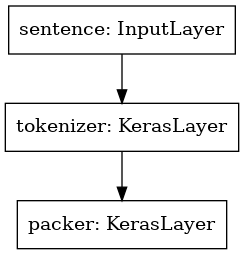

In [5]:
tf.keras.utils.plot_model(test_preprocess_model)

## Configure the text classification model

In [6]:
def build_classifier_model(num_classes, dropout_ratio):
  inputs = dict(
      input_word_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
      input_mask=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
      input_type_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
  )

  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='encoder')
  net = encoder(inputs)['pooled_output']
  net = tf.keras.layers.Dropout(rate=dropout_ratio)(net)
  net = tf.keras.layers.Dense(num_classes, activation=None, name='classifier')(net)
  return tf.keras.Model(inputs, net, name='prediction')

In [7]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
dropout_ratio = 0.1
classes = 2

classifier_model = build_classifier_model(classes, dropout_ratio)

### Test the model

In [8]:
bert_raw_result = classifier_model(text_preprocessed)
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.5493734 0.7861106]], shape=(1, 2), dtype=float32)


### Visualize the model

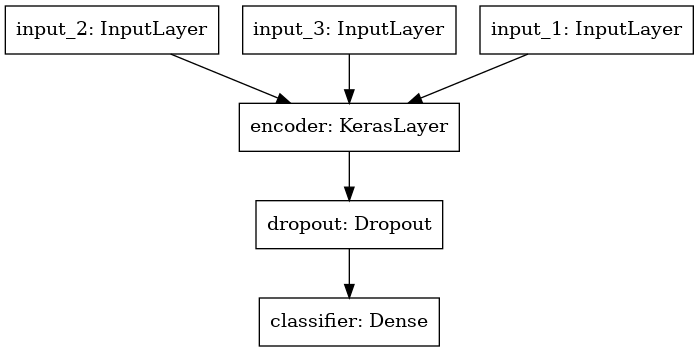

In [9]:
tf.keras.utils.plot_model(classifier_model)

## Configure `tf.data` pipelines

A helper function that creates a new `tf.data` dataset by applying the BERT data preprocessing model to an in-memory `tf.data` dataset with text sentences.

In [10]:
AUTOTUNE = tf.data.AUTOTUNE


def load_dataset_from_tfds(in_memory_ds, info, split, batch_size,
                           bert_preprocess_model):
  is_training = split.startswith('train')
  dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[split])
  num_examples = info.splits[split].num_examples

  if is_training:
    dataset = dataset.shuffle(num_examples)
    dataset = dataset.repeat()
  dataset = dataset.batch(batch_size)
  dataset = dataset.map(lambda ex: (bert_preprocess_model(ex), ex['label']))
  dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
  return dataset, num_examples


### Create the `glue/cola` in-memory `tf.data` dataset

In [11]:
tfds_name = 'glue/cola' 

tfds_info = tfds.builder(tfds_name).info
num_classes = tfds_info.features['label'].num_classes
num_examples = tfds_info.splits.total_num_examples
sentence_features = list(tfds_info.features.keys())
available_splits = list(tfds_info.splits.keys())
sentence_features.remove('idx')
sentence_features.remove('label')

print(f'Using {tfds_name} from TFDS')
print(f'This dataset has {num_examples} examples')
print(f'Number of classes: {num_classes}')
print(f'Features {sentence_features}')
print(f'Splits {available_splits}')

Using glue/cola from TFDS
This dataset has 10657 examples
Number of classes: 2
Features ['sentence']
Splits ['train', 'validation', 'test']


In [12]:
train_split = 'train'
validation_split = 'validation'
test_split = 'test'

with tf.device('/job:localhost'):
  # batch_size=-1 is a way to load the dataset into memory
  in_memory_ds = tfds.load(tfds_name, batch_size=-1, shuffle_files=True)

### Show some samples

In [13]:
sample_dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[train_split])
labels_names = tfds_info.features['label'].names
sample_i = 1
for sample_row in sample_dataset.take(5):
  samples = [sample_row[feature] for feature in sentence_features]
  print(f'sample row {sample_i}')
  for sample in samples:
    print(sample.numpy())
  sample_label = sample_row['label']

  print(f'label: {sample_label} ({labels_names[sample_label]})')
  print()
  sample_i += 1

sample row 1
b'It is this hat that it is certain that he was wearing.'
label: 1 (acceptable)

sample row 2
b'Her efficient looking up of the answer pleased the boss.'
label: 1 (acceptable)

sample row 3
b'Both the workers will wear carnations.'
label: 1 (acceptable)

sample row 4
b'John enjoyed drawing trees for his syntax homework.'
label: 1 (acceptable)

sample row 5
b'We consider Leslie rather foolish, and Lou a complete idiot.'
label: 1 (acceptable)



## Configure a training regimen

### Distribution strategy

We will be training on a single, multi-gpu node. So the strategy will be `mirrored`.

In [14]:
strategy = tf.distribute.MirroredStrategy()

### Optimizer

Fine-tuning follows the optimizer set-up from BERT pre-training (as in [Classify text with BERT](https://www.tensorflow.org/text/tutorials/classify_text_with_bert)): It uses the AdamW optimizer with a linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [15]:
init_lr = 2e-5

optimizer = optimization.create_optimizer(
      init_lr=init_lr,
      num_train_steps=num_train_steps,
      num_warmup_steps=num_warmup_steps,
      optimizer_type='adamw')

NameError: name 'num_train_steps' is not defined

### Compile a model

In [ ]:
dropout_ration = 0.1

bert_preprocess_model = make_bert_preprocess_model(sentence_features)

metrics = tfa.metrics.MatthewsCorrelationCoefficient(num_classes=2)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

with strategy.scope():

  train_dataset, train_data_size = load_dataset_from_tfds(
      in_memory_ds, tfds_info, train_split, batch_size, bert_preprocess_model)
  steps_per_epoch = train_data_size // batch_size
  num_train_steps = steps_per_epoch * epochs
  num_warmup_steps = num_train_steps // 10

  validation_dataset, validation_data_size = load_dataset_from_tfds(
      in_memory_ds, tfds_info, validation_split, batch_size,
      bert_preprocess_model)
  validation_steps = validation_data_size // batch_size

  classifier_model = build_classifier_model(num_classes, dropout_ratio)

  

  classifier_model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])


## Train the model

In [ ]:
epochs = 3
batch_size = 32